## Python for Finance 1

#### Imports

In [1]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data as web # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
import mplfinance as mpf # Matplotlib finance

#### Functions that saves stocks data to CSV

In [2]:
# Function that gets a dataframe by providing a ticker and starting date
def save_to_csv_from_yahoo(ticker, syear, smonth, sday, eyear, emonth, eday):
    
    # Defines the time periods to use
    start = dt.datetime(syear, smonth, sday)
    end = dt.datetime(eyear, emonth, eday)
    
    # Reads data into a dataframe
    df = web.DataReader(ticker, 'yahoo', start, end)

    df.to_csv('../data/' + ticker + '.csv')
    return df

#### Function that returns a dataframe from a CSV

In [3]:
# Reads a dataframe from the CSV file, changes index to date and returns it
def get_df_from_csv(ticker):
    
    # Try to get the file and if it doesn't exist issue a warning
    try:
        df = pd.read_csv('../data/' + ticker + '.csv')
    except FileNotFoundError:
        print("File doesn't exist")
    else:
        return df

#### Add daily return to dataframe

In [4]:
# We calculate a percentage rate of return for each day to compare investments.
# Simple Rate of Return = (End Price - Beginning Price) / Beginning Price OR (EP / BP) - 1

# Shift provides the value from the previous day
# NaN is displayed because there was no previous day price for the 1st calculation

def add_daily_return_to_df(df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    df.to_csv('../data/' + ticker + '.csv')
    return df   

#### Returns total return over time

In [5]:
def get_return_defined_time(df, syear, smonth, sday, eyear, emonth, eday):
    # Create string representations for the dates
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Use a mask to grab data between defined dates
    mask = (df['Date'] >= start) & (df['Date'] <= end)
    
    # Get the mean of the column named daily return
    daily_ret = df.loc[mask]['daily_return'].mean()
    
    # Get the number of days between 2 dates
    df2 = df.loc[mask]
    days = df2.shape[0]

    # Return the total return between 2 dates
    return (days * daily_ret)

#### Matplotlib finance

In [6]:
# Receives a ticker and the date range for which to plot
def mplfinance_plot(ticker, chart_type, syear, smonth, sday, eyear, emonth, eday):
    # Create string representations for the dates
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"

    try:
        df = pd.read_csv('../data/' + ticker + '.csv')
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        
        # Set data.index as DatetimeIndex
        df.index = pd.DatetimeIndex(df['Date'])
        
        # Define to only use data between provided dates
        df_sub = df.loc[start:end]
        
        # A candlestick chart demonstrates the daily open, high, low and closing price of a stock
        mpf.plot(df_sub,type='candle')

        # Plot price changes
        mpf.plot(df_sub,type='line')

        # Moving averages provide trend information (Average of previous 4 observations)
        mpf.plot(df_sub,type='ohlc',mav=4)
        
        # Define a built in style
        s = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 8})
        # Pass in the defined style to the whole canvas
        fig = mpf.figure(figsize=(12, 8), style=s) 
        # Candle stick chart subplot
        ax = fig.add_subplot(2,1,1) 
        # Volume chart subplot
        av = fig.add_subplot(2,1,2, sharex=ax)  

        # You can plot multiple MAVs, volume, non-trading days
        mpf.plot(df_sub,type=chart_type, mav=(3,5,7), ax=ax, volume=av, show_nontrading=True)

#### Simple price plot

In [7]:
# Creates a simple price / date plot between dates
def price_plot(ticker, syear, smonth, sday, eyear, emonth, eday):
    # Create string representations for the dates
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"
    
    try:
        df = pd.read_csv('../data/' + ticker + '.csv')
    except FileNotFoundError:
        print("File Doesn't Exist")
    else:
        
        # Set data.index as DatetimeIndex
        df.index = pd.DatetimeIndex(df['Date'])
        
        # Define to only use data between provided dates
        df_sub = df.loc[start:end]
        
        # Convert to Numpy array
        df_np = df_sub.to_numpy()
        
        # Get adjusted close data from the 5th column
        np_adj_close = df_np[:,5]
        
        # Get date from the 1st
        date_arr = df_np[:,1]
        
        # Defines area taken up by the plot
        fig = plt.figure(figsize=(12,8),dpi=100)
        axes = fig.add_axes([0,0,1,1])
        
        # Define the plot line color as navy
        axes.plot(date_arr, np_adj_close, color='navy')
        
        # Set max ticks on the x axis
        axes.xaxis.set_major_locator(plt.MaxNLocator(8))
        
        # Add a grid, color, dashes(5pts 1 pt dashes separated by 2pt space)
        axes.grid(True, color='0.6', dashes=(5, 2, 1, 2))
        
        # Set grid background color
        axes.set_facecolor('#FAEBD7')

#### Download multiple stocks

In [8]:
def download_multiple_stocks(syear, smonth, sday, eyear, emonth, eday, *args):
    for x in args:
        save_to_csv_from_yahoo(x, syear, smonth, sday, eyear, emonth, eday)

#### Merge multiple stocks in one dataframe by column name

In [9]:
def merge_df_by_column_name(col_name, syear, smonth, sday, eyear, emonth, eday, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"
    
    for x in tickers:
        mult_df[x] = web.DataReader(x, 'yahoo', start, end)[col_name]
        
    return mult_df

#### Get changing value of investment using multiple stocks

In [10]:
def plot_return_mult_stocks(investment, stock_df):
    (stock_df / stock_df.iloc[0] * investment).plot(figsize = (15,6))

#### Get standard deviation for multiple stocks

Risk is a measure of the variability of return. Variance and Standard Deviation allow us to quantify risk.

Variance is a measure of how spread out a data set is. It is calculated as the average squared deviation of each number from the mean of a data set.n It equals the sum of the squares of the difference between each data point and the mean divided by the number of data points minus 1.

$s^2 = \frac{\sum (x - \hat{x})^2}{N-1}$

Example : If we have 3 annual returns of 23%, -8% and 15%. The mean return is 10%.

- $(23 - 10)^2 = 169$
- $(-8 -10)^2 = 324$
- $(15 - 10)^2 = 25$
- $169 + 324 + 25 = 518 / (3-1) = 259 = 2.59$

Standard deviation is a measure of the amount of variation within a set of values. A low standard deviation indicates that the values tend to be close to the mean. A high standard deviation means values are more spread out. To get the Standard Deviation find the square root of the variance.

$\sqrt{s^2} = \sqrt{2.59} = 1.609$

In [11]:
# Receives the dataframe with the Adj Close data along with the stock ticker
# Returns the mean and standard deviation associated with the ticker
def get_stock_mean_sd(stock_df, ticker):
    return stock_df[ticker].mean(), stock_df[ticker].std()

In [12]:
# Receives the dataframe with the stock ticker as the column name and
# the Adj Close values as the column data and returns the mean and 
# standard deviation
def get_mult_stock_mean_sd(stock_df):
    for stock in stock_df:
        mean, sd = get_stock_mean_sd(stock_df, stock)
        cov = sd / mean
        print("Stock: {:4} Mean: {:7.2f} Standard deviation: {:2.2f}".format(stock, mean, sd))
        print("Coefficient of Variation: {}\n".format(cov))

---

Test functions

Total Return : 0.6166401575831238
Stock: FB   Mean:  234.55 Standard deviation: 38.57
Coefficient of Variation: 0.1644238149761194

Stock: AMZN Mean: 2680.86 Standard deviation: 545.76
Coefficient of Variation: 0.20357722570815504

Stock: AAPL Mean:   94.20 Standard deviation: 21.76
Coefficient of Variation: 0.23099016212654525

Stock: NFLX Mean:  446.83 Standard deviation: 65.61
Coefficient of Variation: 0.14684116488739776

Stock: GOOG Mean: 1481.40 Standard deviation: 175.97
Coefficient of Variation: 0.11878452933446867



,FB,AMZN,AAPL,NFLX,GOOG
Date,,,,,
2020-01-02,209.779999,1898.010010,73.785912,329.809998,1367.369995
2020-01-03,208.669998,1874.969971,73.068558,325.899994,1360.660034
2020-01-06,212.600006,1902.880005,73.650795,335.829987,1394.209961
2020-01-07,213.059998,1906.859985,73.304413,330.750000,1393.339966
2020-01-08,215.220001,1891.969971,74.483612,339.260010,1404.319946
...,...,...,...,...,...
2020-12-24,267.399994,3172.689941,130.802322,513.969971,1738.849976
2020-12-28,277.000000,3283.959961,135.480591,519.119995,1776.089966
2020-12-29,276.779999,3322.000000,133.676682,530.869995,1758.719971


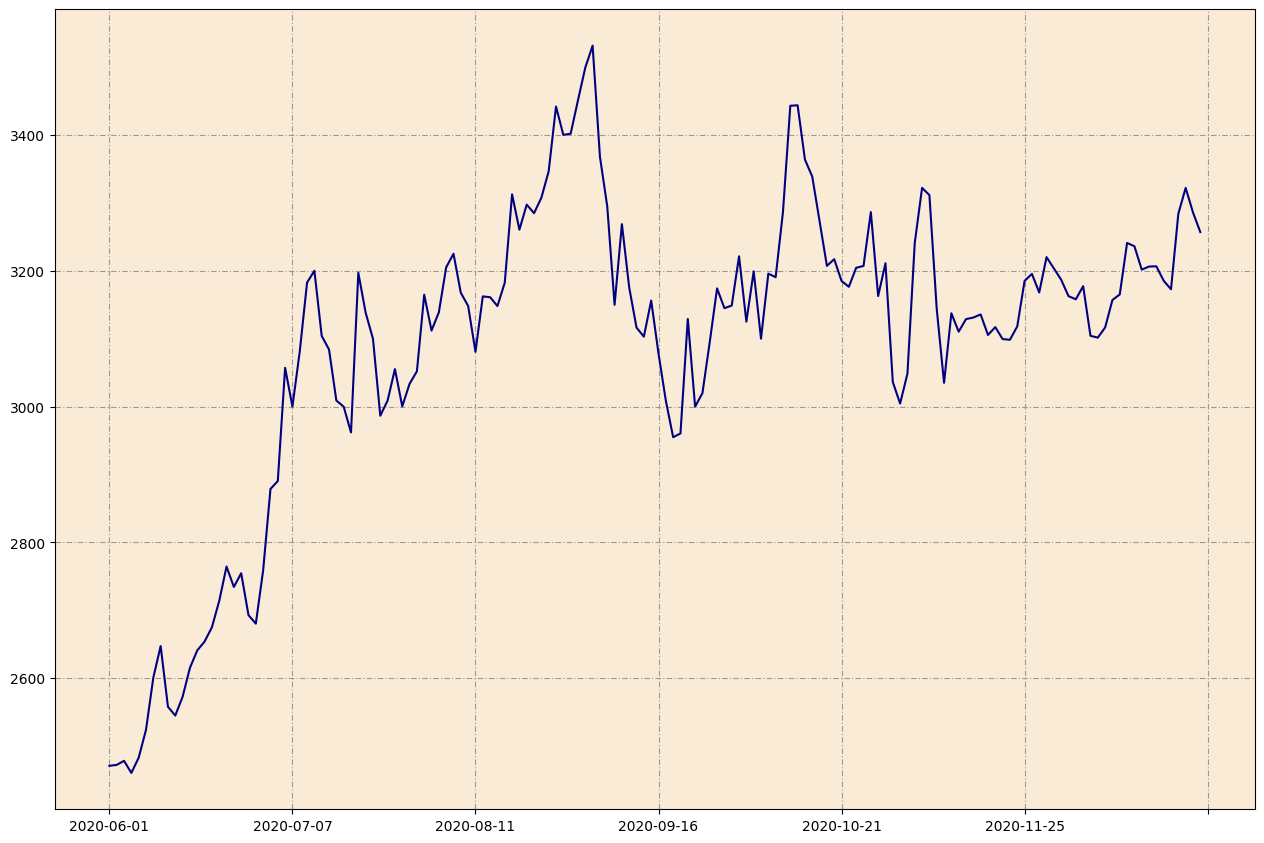

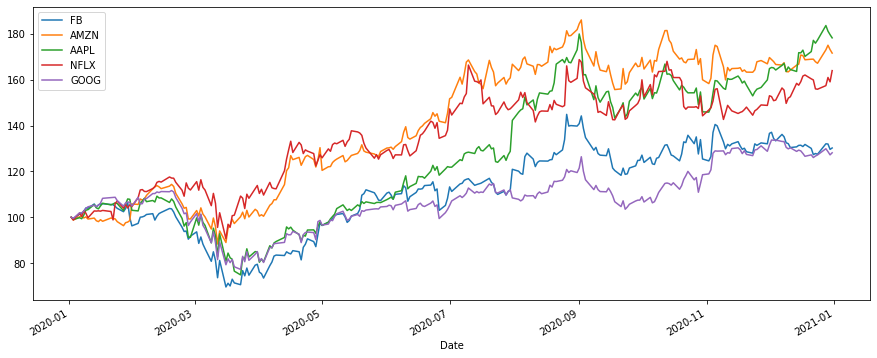

In [13]:
# Call to read the data from Yahoo into a CSV and then retrieve a Dataframe
AMZN = save_to_csv_from_yahoo('AMZN', 2020, 1, 1, 2021, 1, 1)

# Retrieve data from the CSV file
AMZN = get_df_from_csv('AMZN')

# Add daily return to function
add_daily_return_to_df(AMZN, 'AMZN')

# Get total return between dates
tot_ret = get_return_defined_time(AMZN, 2020, 1, 1, 2021, 1, 1)
print("Total Return :", tot_ret)

# Use Matplotlib finance to print multiple charts
# mplfinance_plot('AMZN', 'ohlc', 2020, 6, 1, 2021, 1, 1)

price_plot('AMZN', 2020, 6, 1, 2021, 1, 1)

# Download multiple stocks
tickers = ["FB", "AAPL", "NFLX", "GOOG"]
# download_multiple_stocks(2020, 1, 1, 2021, 1, 1, *tickers)

# Merge dataframes from multiple stocks using the same column name
tickers = ["FB", "AMZN", "AAPL", "NFLX", "GOOG"]
mult_df = merge_df_by_column_name('Adj Close',  2020, 1, 1, 2021, 1, 1, *tickers)
mult_df.tail()

# Pass Investment Amount and Plot Returns using Multiple Stocks
plot_return_mult_stocks(100, mult_df)

# Pass multiple stocks with their adjusted close values to receive their
# different means and standard deviations
get_mult_stock_mean_sd(mult_df)
mult_df

# It is hard to compare stocks by standard deviation when their stock prices
# are so different. The coefficient of variation is the ratio between the 
# standard deviation and the mean and it provides a comparable standard deviation
# We get it by dividing the standard deviation by the mean cov = std / mean
# We see here that GOOG has the least amount of variability